In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import nbformat
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

In [2]:
TEMP_LOW_LIMIT = -459.67
TEMP_HIGH_LIMIT = 1000
RPM_LOW_LIMIT = 0
RPM_HIGH_LIMIT = 6e8  # the largest achieved rpm of all human artifacts

def exclude_physical_anml(df):
    result = df[(df['motor_temp'] > TEMP_LOW_LIMIT) & (df['inlet_temp'] > TEMP_LOW_LIMIT) & (df['rpm'] > 0) & (df['rpm'] < RPM_HIGH_LIMIT)]
    return result

def peek_attributes_trend(attribute, ylim_low=-10, ylim_high=1500):
    units = ["000{}".format(num) if num < 10 else "00{}".format(num) for num in random.sample(range(0, 20), 9)]
    file_names = ["../data/raw/train/unit{}_rms.csv".format(unit) for unit in units]
    sns.set()
    f, axs = plt.subplots(3, 3, figsize=(20, 12))
    for idx, file_name in enumerate(file_names):
        file_df = pd.read_csv(file_name)
        file_df = exclude_physical_anml(file_df)
        ax1 = plt.subplot(3, 3, idx + 1)
        file_df[attribute].plot(ylim=(ylim_low, ylim_high))
    plt.show()
    
def load_file(unit, file_type='rms'):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    df = pd.read_csv('../data/raw/train/unit{}_{}.csv'.format(unit_name, file_type))
    if file_type == 'rms':
        df = exclude_physical_anml(df)
    return df

def load_all_files():
    units = range(0, 20)
    df_all = pd.DataFrame()
    for idx, unit in enumerate(units):
        file_name = "../data/processed/train/unit{}_rms_anomaly_excluded.csv".format("000{}".format(unit) if unit < 10 else "00{}".format(unit))
        file_df = pd.read_csv(file_name, index_col=0)
        file_df['unit'] = unit
        df_all = df_all.append(file_df)
    return df_all

def transform_column(df_input):
    num_features = df_input.columns[1:]
    num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_features)
    ])
    np_pipelined = full_pipeline.fit_transform(df_input)
    df_pipelined = pd.DataFrame(np_pipelined, index=df_input.index)
    return df_pipelined

In [3]:
df_all = load_all_files()
df_all

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit
50,2003-12-14 04:15:20.899117138,1063.729373,165.879228,19.281104,35.767971,26.387341,0
53,2003-12-14 04:45:12.721247385,956.579922,217.484012,25.042943,63.002208,34.350839,0
54,2003-12-14 04:55:40.840586778,1063.856934,206.792646,28.782024,69.830473,28.464714,0
55,2003-12-14 05:05:37.291038943,1005.212018,219.900341,29.302032,68.019838,39.165607,0
56,2003-12-14 05:17:06.465193131,1115.011284,220.373208,30.767473,79.283341,32.983723,0
...,...,...,...,...,...,...,...
24341,2005-04-11 18:16:25.989419843,1042.179737,307.539123,47.975455,218.791347,100.807647,19
24342,2005-04-11 18:26:55.689073846,1069.597134,297.454082,47.263750,218.882763,109.359761,19
24343,2005-04-11 18:35:25.402556965,1116.392388,316.277175,50.395914,218.935540,102.472228,19
24344,2005-04-11 18:45:44.900113142,1122.974015,320.776152,49.165122,225.527057,103.086940,19


PCA attempt for dimensionality reduction

[0.64540183 0.16622793]


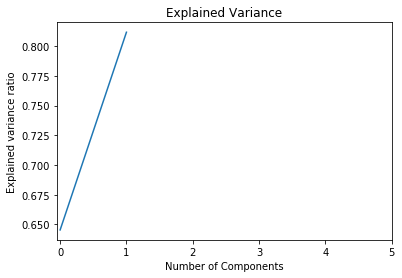

In [4]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(transform_column(df_all))
print(pca.explained_variance_ratio_)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained variance ratio")
plt.title("Explained Variance")
plt.xticks(np.arange(0, 6, 1))
plt.show()

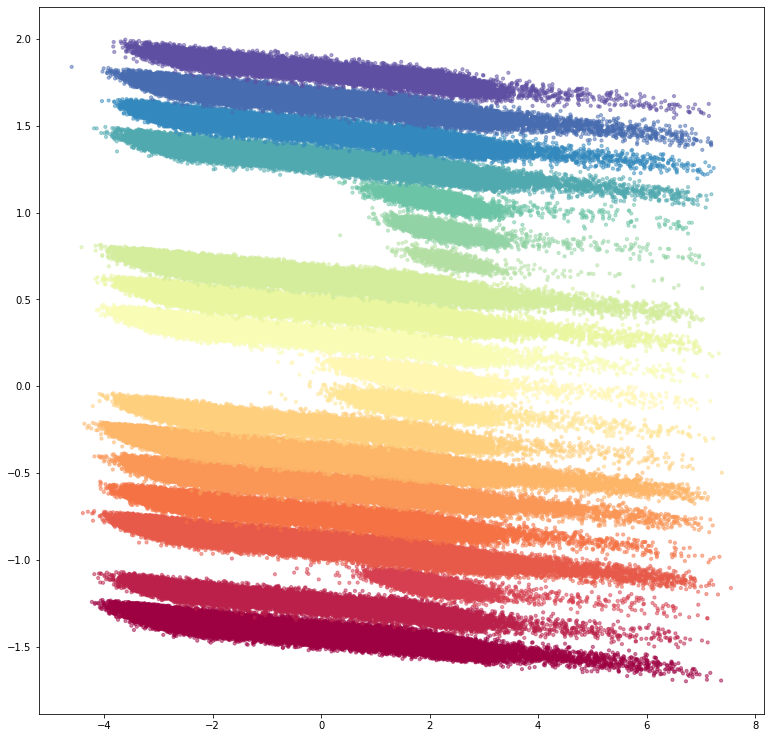

In [42]:
fig, ax = plt.subplots(figsize=(13, 13))
plt.scatter(x=[p[0] for p in pca_result], y=[p[1] for p in pca_result], c=df_all['unit'], cmap='Spectral', marker='o', alpha=0.5, s=10)
plt.show()

Merging all train data and plot on 2D plain using TSNE

In [11]:
tsne_model_all = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=0, random_state=0, angle=0.75)
tsne_vectors_all = tsne_model_all.fit_transform(transform_column(df_all))

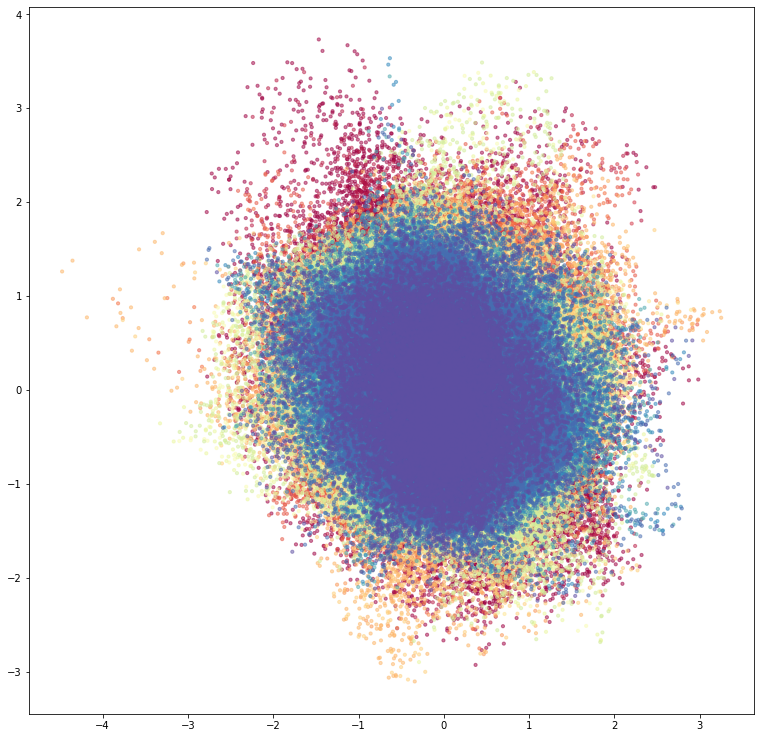

In [12]:
fig, ax = plt.subplots(figsize=(13, 13))
tsne_vectors_all_scaled = tsne_vectors_all * 1e5
plt.scatter(x=tsne_vectors_all_scaled[:, 0], y=tsne_vectors_all_scaled[:, 1], marker='o', c=df_all['unit'], cmap='Spectral', alpha=0.5, s=10)
plt.show()

In [ ]:
dbscan = DBSCAN(eps=15, min_samples=5)
print("model initialized")
dbscan.fit(df_all[df_all.columns[1:]])
print("model trained")
dump(dbscan, '../models/clustering/all_units_dbscan.joblib')
print("model saved")
dbscan.labels_

model initialized


In [6]:
dbscan = load('../models/clustering/all_units_dbscan.joblib')
set(dbscan.labels_)

{-1, 0, 1, 2, 3}

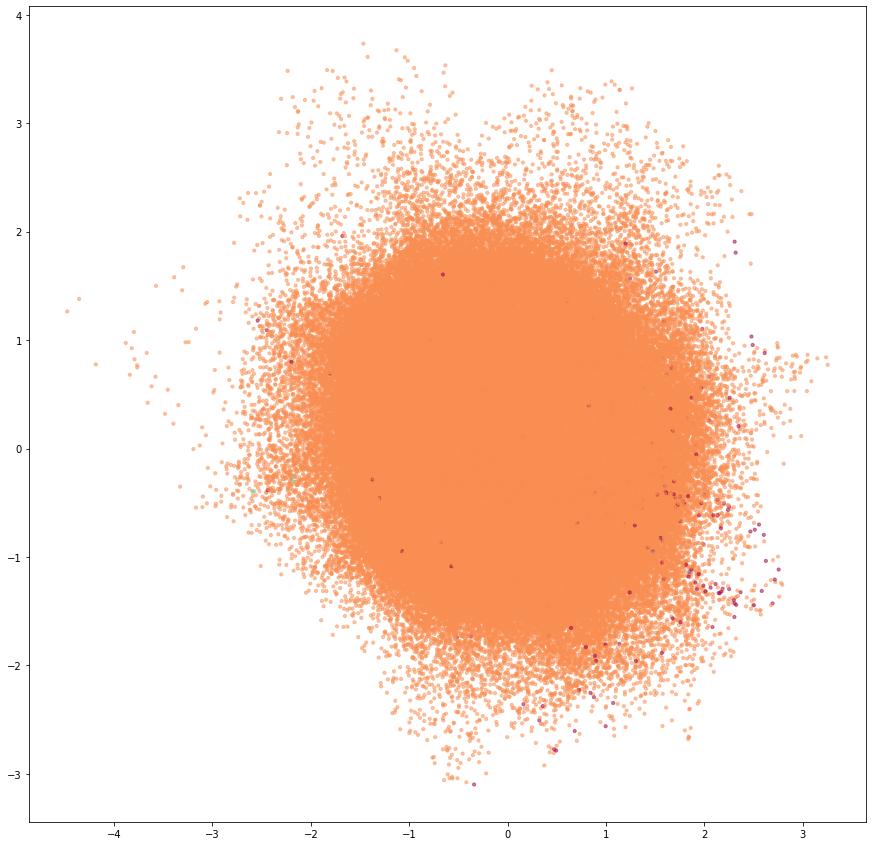

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(x=tsne_vectors_all_scaled[:, 0], y=tsne_vectors_all_scaled[:, 1], c=dbscan.labels_, cmap='Spectral', marker='o', alpha=0.5, s=10)
plt.show()

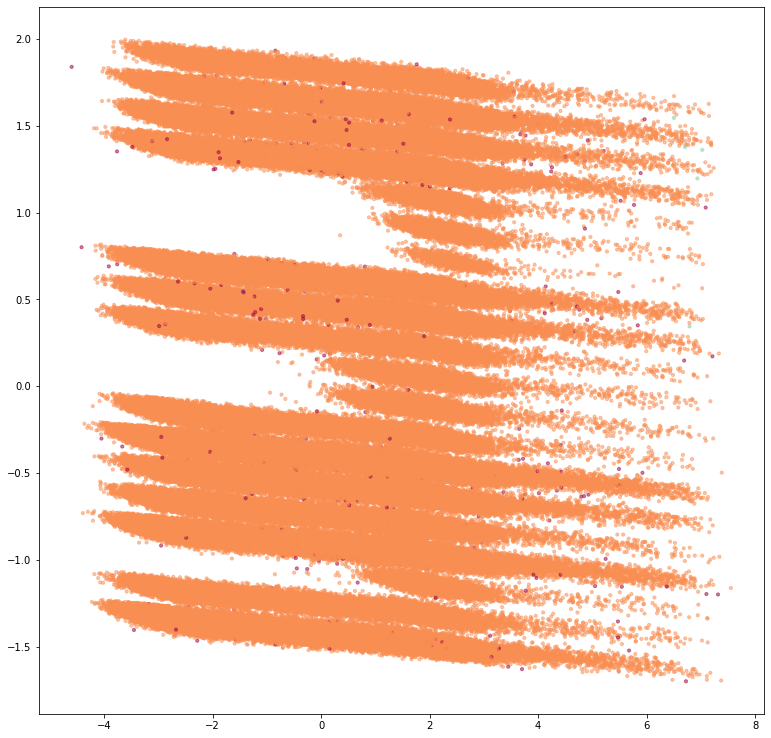

In [7]:
fig, ax = plt.subplots(figsize=(13, 13))
plt.scatter(x=[p[0] for p in pca_result], y=[p[1] for p in pca_result], c=dbscan.labels_, cmap='Spectral', marker='o', alpha=0.5, s=10)
plt.show()